In [17]:
import numpy as np
from obp.dataset import logistic_reward_function
from obp.dataset import SyntheticBanditDataset
from obp.ope import SelfNormalizedInverseProbabilityWeighting as SNIPS
from obp.ope import SelfNormalizedMarginalizedInverseProbabilityWeighting as SMIPS
from obp.ope import InverseProbabilityWeighting as IPS
import pandas as pd
from policy import gen_eps_greedy

from src.libs.utils import prepare_cls_data
from src.libs.classification import Classifier
from src.models.mlp import TwoTowerClassifier, MLPClassifier

from src.utils import read_yaml

from tqdm import tqdm 

from obp.ope import OffPolicyEvaluation
from obp.ope import BalancedInverseProbabilityWeighting as BIPW
from obp.utils import sample_action_fast

from src.custom_estimators import NaiveMethod as NM
from src.models.obp import Policy, softmax_from_reward, greedy, content_based_filtering

from functools import partial
from copy import deepcopy

import time
from datetime import datetime

import os
import shutil

In [18]:
cfg_path = 'src/phase1/config.yaml'
cfg = read_yaml(cfg_path)

random_state = cfg['random_state']
np.random.seed(random_state)

cfg

{'n_round': 10000,
 'n_actions': 500,
 'dim_context': 5,
 'dim_context_unobserved': 0,
 'dim_action': 20,
 'dim_action_unobserved': 5,
 'beta_log': -5,
 'reward_std': 2.5,
 'n_def_actions': 0,
 'random_state': 12345,
 'n_bootstrap_set': 10,
 'bootstrap_set_size': 2000}

In [19]:
current_timestamp = time.time()
current_datetime = datetime.fromtimestamp(current_timestamp)
exp_name = current_datetime.strftime("%Y%m%d%H%M%S")

os.makedirs('experiments/' + exp_name)
shutil.copy2(cfg_path, 'experiments/' + exp_name)


'experiments/20231223131520/config.yaml'

In [20]:
def bootstrap_bandit(bandit_data, n_set, set_size, random_state):

    np.random.seed(random_state)

    idxs = np.arange(bandit_data['n_rounds'])
    bootstrap_sets = []
    for i in range(n_set):
        sample_idx = np.random.choice(idxs, set_size)

        bandit_data_ = {}

        bandit_data_['n_rounds'] = set_size
        bandit_data_['n_actions'] = bandit_data['n_actions']
        bandit_data_['action_context'] = bandit_data['action_context']

        keys = ['context', 'action', 'position', 'reward', 
                'expected_reward', 'pi_b', 'pscore']
        
        for key in keys:
            if bandit_data[key] is not None:
                bandit_data_[key] = bandit_data[key][sample_idx]
            else:
                bandit_data_[key] = None


        bootstrap_sets.append(bandit_data_)

    return bootstrap_sets

In [21]:


result = []

action_context = np.random.normal(size=(cfg['n_actions'], cfg['dim_action']))
dataset = SyntheticBanditDataset(
    n_actions=cfg['n_actions'],
    dim_context=cfg['dim_context'],
    action_context=action_context,
    beta=cfg['beta_log'],
    reward_type="binary",
    n_deficient_actions=int(cfg['n_actions'] * cfg['n_def_actions']),
    reward_function=logistic_reward_function,
    reward_std=cfg['reward_std'],
    random_state=random_state,
)

bandit_data = dataset.obtain_batch_bandit_feedback(
    n_rounds=cfg['n_round'],
)

bandit_datas = bootstrap_bandit(bandit_data, cfg['n_bootstrap_set'], cfg['bootstrap_set_size'], random_state)

policies = [
    {'func': softmax_from_reward, 'kwargs': {'beta': -1}},
    {'func': softmax_from_reward, 'kwargs': {'beta': 5}},
    {'func': greedy, 'kwargs': {'beta': 0.2}},
    {'func': greedy, 'kwargs': {'beta': 0.6}},
    {'func': content_based_filtering, 'kwargs': {}},
]

for trial, bandit_data_bs in tqdm(enumerate(bandit_datas), total=len(bandit_datas)):

    bandit_data_bs['context_obs'] = bandit_data_bs['context'][:, :cfg['dim_context'] - cfg['dim_context_unobserved']]
    bandit_data_bs['action_context_obs'] = bandit_data_bs['action_context'][:, :cfg['dim_action'] - cfg['dim_action_unobserved']]
    bandit_data_bs["action_embed"] = bandit_data_bs['action_context'][bandit_data_bs['action']]
    bandit_data_bs["action_embed_obs"] = bandit_data_bs['action_context_obs'][bandit_data_bs['action']]

    for policy in policies:

        pol_func = policy['func']
        kwargs = policy['kwargs']

        # action_dist_tar = gen_eps_greedy(
        #     expected_reward=bandit_data_bs["expected_reward"],
        #     is_optimal=True,
        #     eps=beta,
        # )

        # target_policy = Policy(n_actions=dataset.n_actions, model=None, bandit_feedback=bandit_data_bs, beta=beta)
        # action_dist_tar = target_policy.predict_proba(bandit_data_bs['context'], tau=1)

        pol_str = pol_func.__name__ +'_' + '_'.join([k+'='+str(v) for k, v in kwargs.items()])

        kwargs_ = deepcopy(kwargs)
        kwargs_['bandit_data'] = bandit_data_bs 
        action_dist_tar = pol_func(**kwargs_)

        action_tar = sample_action_fast(action_dist_tar[:,:,0], 1234)

        pol_val = dataset.calc_ground_truth_policy_value(
            expected_reward=bandit_data_bs["expected_reward"],
            action_dist=action_dist_tar,
        )

        

        model = MLPClassifier(bandit_data_bs['context_obs'].shape[1], 
                              bandit_data_bs['action_context_obs'].shape[1], 
                              32)
        # model = TwoTowerClassifier(cfg['dim_context'], cfg['latent_param_mat_dim'], 32)

        clstrainer = Classifier(bandit_data_bs, action_tar, model, 10, verbose=False)

        X = np.hstack([clstrainer.context, clstrainer.action_emb])
        X_log, X_tar = np.split(X, 2)

        clstrainer.train()

        probs = clstrainer.predict()
        imp_weights = probs / (1-probs)
        imp_weights = imp_weights / imp_weights.mean()
        # imp_weights = np.minimum(imp_weights, 10000)

        
        ope_estimators = [
                    NM(estimator_name='NM'),
                    SNIPS(estimator_name="SNIPS"),
                    IPS(estimator_name="IPS"),
                    SMIPS(
                        n_actions=bandit_data_bs["n_actions"],
                        estimator_name="SMIPS"
                    ),
                    BIPW(
                        estimator_name="BIPW"
                    ),
                    # RECAP(estimator_name="RECAP")
        ]

        ope = OffPolicyEvaluation(
                bandit_feedback=bandit_data_bs,
                ope_estimators=ope_estimators,
            )

        estimated_policy_values = ope.estimate_policy_values(
            action_dist=action_dist_tar,
            estimated_importance_weights=imp_weights,  #########################
            action_embed=bandit_data_bs["action_embed_obs"],
            pi_b=bandit_data_bs["pi_b"]
        )

        estimated_policy_values['true_val'] = pol_val
        estimated_policy_values['policy'] = pol_str
        estimated_policy_values['trial'] = trial
        #print(estimated_policy_values)

        # print(estimated_policy_values)
        result.append(estimated_policy_values)


100%|██████████| 10/10 [20:23<00:00, 122.36s/it]


In [22]:
result_df = pd.DataFrame(result)
result_df.to_csv('experiments/' + exp_name + '/result.csv')

result_by_pol = result_df.groupby('policy').mean()
print(result_by_pol)
print(result_df.groupby('policy').var())

                                   NM     SNIPS       IPS     SMIPS      BIPW  \
policy                                                                          
content_based_filtering_     0.001200  0.751085  0.771165  0.338751  0.239269   
greedy_beta=0.2              0.002040  0.536719  1.155162  0.277928  0.203077   
greedy_beta=0.6              0.001940  0.515859  0.444143  0.227236  0.127161   
softmax_from_reward_beta=-1  0.002010  0.580182  0.556084  0.272222  0.145314   
softmax_from_reward_beta=5   0.001937  0.588232  0.572887  0.273088  0.135764   

                             true_val  trial  
policy                                        
content_based_filtering_     0.725371    4.5  
greedy_beta=0.2              0.596892    4.5  
greedy_beta=0.6              0.582052    4.5  
softmax_from_reward_beta=-1  0.582756    4.5  
softmax_from_reward_beta=5   0.596086    4.5  
                                       NM     SNIPS       IPS     SMIPS  \
policy                      

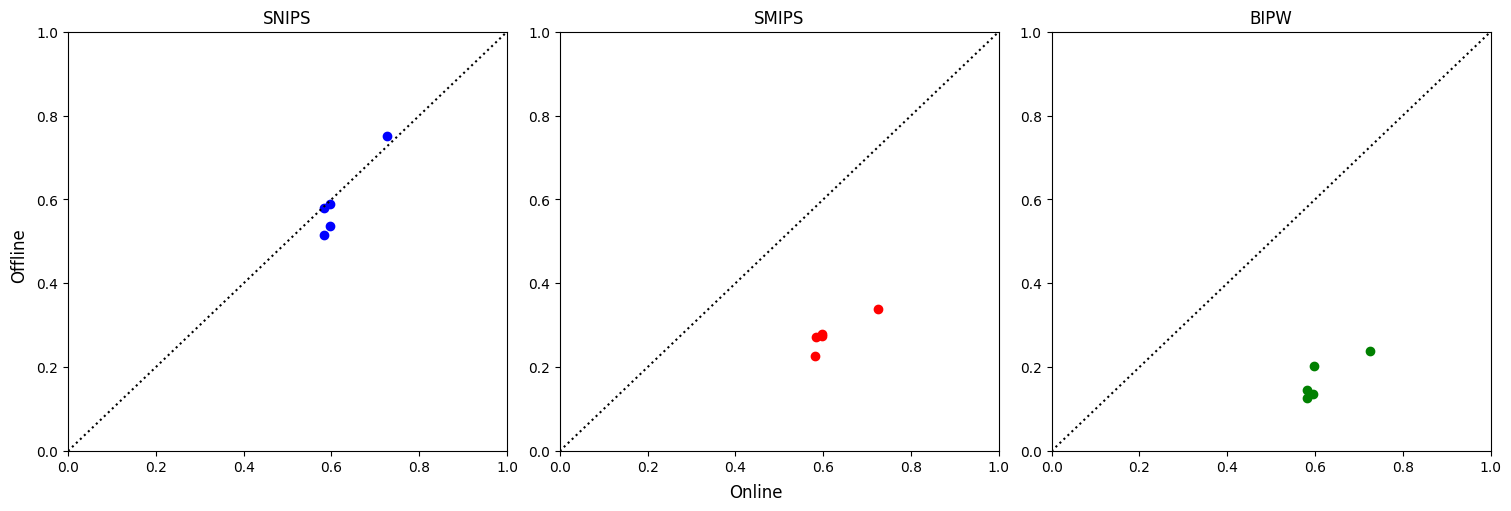

In [23]:
import matplotlib.pyplot as plt 

pols2plot = ['SNIPS', 'SMIPS', 'BIPW']
colors = ['b', 'r', 'g']

fig, axs = plt.subplots(1, len(pols2plot), figsize=(5*len(pols2plot), 5), constrained_layout=True)

for i, pol in enumerate(pols2plot):

    axs[i].plot([0,1], [0,1], ':', c='k')
    axs[i].scatter(result_by_pol['true_val'], result_by_pol[pol], c=colors[i])
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_title(pol)

fig.supxlabel('Online')
fig.supylabel('Offline')
plt.show()

fig.savefig('experiments/' + exp_name + '/online-offline_plot.png')